In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data.dataset import COWCDataset, OIRDSDataset
from model.loss import RegClsLoss, MinDistLoss
from model.model import VGGRegCls
from utils.train import train_model
from utils.receptive_field import *
import glob
import torch
import torchvision

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [3]:
file_list = []
path_train = '/home/kruglov/projects/siod/datasets/cowc/{}/train/*'
path_test = '/home/kruglov/projects/siod/datasets/cowc/{}/test/*'

In [4]:
for ds in ['Selwyn_LINZ','Columbus_AFRL','Potsdam_ISPRS']:
    file_list = file_list + glob.glob(path_train.format(ds)) + glob.glob(path_test.format(ds))
print('Datasets have {} images in total.'.format(len(file_list)))

Datasets have 42683 images in total.


In [5]:
batch_size = 4

In [6]:
dataset = COWCDataset(file_list, transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle= True)

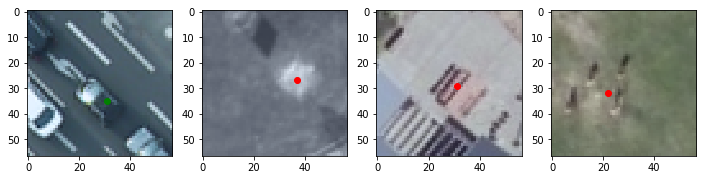

In [7]:
# Sample images from datasets
# positive examples labeled with green marks

inputs, labels = iter(dataloader).next()
coords = labels.data.numpy() * 10 + 28
plt.figure(figsize= (12,3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    mark = 'go' if labels[i][2] == 1 else 'ro'
    plt.imshow(np.clip(np.transpose(inputs[i], (1,2,0)) * 0.22 + 0.45, 0, 1))
    plt.plot(coords[i][0], coords[i][1], mark);

In [8]:
model = VGGRegCls().cuda()
criterion = RegClsLoss()
optimizer = torch.optim.SGD(params= model.parameters(), lr= 0.0001, weight_decay= 0.9)

In [9]:
results = train_model(model, criterion, optimizer, dataloader, iterations= 10)

Epoch 0, loss 0.9829819798469543
Epoch 1, loss 1.0915898382663727
Epoch 2, loss 0.8948851466178894
Epoch 3, loss 0.9767528057098389
Epoch 4, loss 1.160835760831833
Epoch 5, loss 0.9432879269123078
Epoch 6, loss 1.0190155148506164
Epoch 7, loss 0.92182537317276
Epoch 8, loss 0.8873205661773682
Epoch 9, loss 0.8200941264629364
Finished training!


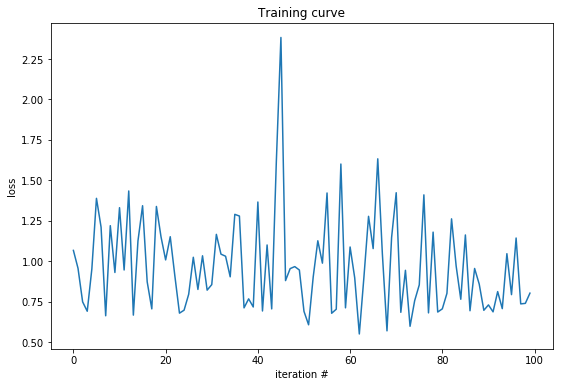

In [10]:
plt.figure(figsize= (9,6))
plt.title('Training curve'); plt.xlabel('iteration #'); plt.ylabel('loss');
plt.plot(results['train_loss_list']);

In [11]:
model.train(False);

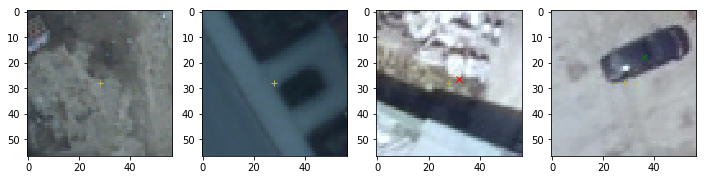

In [12]:
inputs, labels = iter(dataloader).next()
outputs_l, outputs_c = model(torch.autograd.Variable(inputs).cuda())

pred_coords = outputs_l.cpu().data.numpy() * 10 + 28
gt_coords = labels.data.numpy() * 10 + 28

plt.figure(figsize= (12,3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i+1)
    if float(labels[i,2]) > 0:
        plt.plot(gt_coords[i][0], gt_coords[i][1], 'gx')
    if float(outputs_c[i][1].cpu().data) > 0.5:
        plt.plot(pred_coords[i][0], pred_coords[i][1], 'rx')
    plt.plot(28,28,'y+')
    plt.imshow(np.clip(np.transpose(inputs[i], (1,2,0)) * 0.25 + 0.46, 0, 1));

In [13]:
convnet = [[3,1,1],[3,1,1],[2,2,0],[3,1,1],[3,1,1],[2,2,0],[3,1,1],[3,1,1],[3,1,1],[2,2,0],[13,1,3],[1,1,0]]
layer_names = ['conv1_1','conv1_2','pool1','conv2_1','conv2_2','pool2','conv3_1','conv3_2','conv3_3','pool2','conv4_1','conv4_2']
imsize = 257

In [14]:
layerInfos = get_receptive_fields(convnet, imsize)

In [15]:
rf_centers = torch.zeros(outputs_l.shape).cuda()

for i in range(rf_centers.shape[2]):
    for j in range(rf_centers.shape[3]):
        rf_x, rf_y = receptive_field_center(layer_names, layerInfos, j, i, 'conv4_2')
        
        rf_centers[0,0,i,j] = rf_x
        rf_centers[0,1,i,j] = rf_y

In [16]:
criterion = MinDistLoss(rf_centers)

In [17]:
for m in model.regression.modules():
    m.requires_grad = False

In [18]:
data_path = '/home/kruglov/projects/siod/faster-rcnn/no-rcnn/data/OIRDS/train/'

In [19]:
target_split = pd.read_pickle('/home/kruglov/projects/siod/faster-rcnn/no-rcnn/data/target_split.pickle')

In [20]:
dataset = OIRDSDataset(data_path, target_split.index.values, target_split.values, transform)
dataloader = torch.utils.data.DataLoader(dataset, 1, True)

In [ ]:
train_model(model, criterion, optimizer, dataloader, epochs= 10, iterations= 10)

Epoch 0, loss 1.4114462733268738
Epoch 1, loss 1.700657308101654
Epoch 2, loss 1.4068001508712769
Epoch 3, loss 1.4053279638290406
Epoch 4, loss 1.550914716720581
Epoch 5, loss 1.3997287988662719
